In [1]:
import re
import time
import math
import random
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
SEED = 42
EMBEDDING_DIM = 128
HIDDEN_DIM = 128

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ALL_LETTERS = string.ascii_letters + '#'
N_LETTERS = len(ALL_LETTERS)

## Helpers

In [3]:
def unicodeToAscii(word):
    return ''.join(
        c for c in unicodedata.normalize('NFD', word)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def clean_text(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text) # remove numbers
    text = re.sub(r' +', ' ', text) #  remove more than one space
    return text

def inputTensor(word):
    letter_indexes = [ALL_LETTERS.find(word[li]) for li in range(len(word))]
    return torch.LongTensor(letter_indexes)

def targetTensor(word):
    letter_indexes = [ALL_LETTERS.find(word[li]) for li in range(1, len(word))]
    letter_indexes.append(N_LETTERS-1)
    return torch.LongTensor(letter_indexes)

def randomTrainingExample(words):
    word = words[random.randint(0, len(words) - 1)]
    input_tensor = inputTensor(word)
    target_tensor = targetTensor(word)
    return input_tensor, target_tensor

## Greek myphology wordlist

In [5]:
greek_myth_wordlist = []
with open("data/startup-name-generation/greek_names.txt", 'r', encoding='utf-8') as f:
    greek_myth_wordlist = f.readlines()

## Other Greek wordlist

In [6]:
greek_wordlist = []
with open("data/startup-name-generation/greek.txt", 'r', encoding='utf-8') as f:
    greek_wordlist = f.readlines()

## Gallic wordlist

In [7]:
gallic_wordlist = []
with open("data/startup-name-generation/gallic.txt", 'r', encoding='utf-8') as f:
    gallic_wordlist = f.readlines()

## Latin wordlist

In [8]:
latin_wordlist = []
with open("data/startup-name-generation/latin.txt", 'r', encoding='utf-8') as f:
    latin_wordlist = f.readlines()

## Lorem ipsum

In [9]:
lorem_ipsum_wordlist = []
with open("data/startup-name-generation/lorem-ipsum.txt", 'r', encoding='utf-8') as f:
    lorem_ipsum_wordlist = f.readlines()

## Text cleaning and vocab preparation

In [10]:
all_wordlists = greek_myth_wordlist+greek_wordlist+gallic_wordlist+lorem_ipsum_wordlist
all_wordlists = [word for item in all_wordlists for word in item.strip().split()]

In [11]:
df = pd.DataFrame(data=all_wordlists, columns=['words'])
df.head()

,words
0,Abas
1,Abderus
2,Abia
3,Abrota
4,Acallaris


In [12]:
df['words'] = df['words'].map(clean_text)
df['words'] = df['words'].map(unicodeToAscii)

In [16]:
print(f"There are {df.duplicated().sum()} duplicates in the data")

There are 0 duplicates in the data


In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df['length'] = df['words'].apply(lambda x: len(x))
df = df[df['length'] > 2]

In [19]:
print(f"There are {df.shape[0]} word samples")

There are 4215 word samples


In [20]:
inputTensor("Zeus")

tensor([51,  4, 20, 18])

In [21]:
targetTensor("Zeus")

tensor([ 4, 20, 18, 52])

In [18]:
# class LSTMGenerator(nn.Module):

#     def __init__(self, 
#                  embedding_dim, 
#                  hidden_dim, 
#                  vocab_size, 
#                  tagset_size, 
#                  bidirectional=True,
#                  dp_rate=0.5):
#         super(LSTMGenerator, self).__init__()
        
#         self.hidden_dim = hidden_dim
#         self.dp_rate = dp_rate
#         self.bidirectional = bidirectional

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
#         self.lstm = nn.LSTM(input_size=embedding_dim, 
#                             hidden_size=hidden_dim,
#                             dropout=self.dp_rate,
#                             bidirectional=self.bidirectional)

#         self.hidden2output = nn.Linear(hidden_dim, tagset_size)

#     def forward(self, char_ids):
#         embeds = self.word_embeddings(char_ids)
#         lstm_out, _ = self.lstm(embeds.view(len(char_ids), 1, -1))
#         outputs = self.hidden2output(lstm_out.view(len(char_ids), -1))
#         outputs_scores = F.log_softmax(outputs, dim=1)
#         return outputs_scores

In [22]:
class LSTMGenerator(nn.Module):

    def __init__(self,
                 embedding_dim, 
                 hidden_size,
                 vocab_size,     
                 num_classes,
                 num_layers=1,
                 bidirectional=False,
                 dp_rate=0.5):
        
        super(LSTMGenerator, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        if num_layers == 1:
            self.dp_rate = 0.0
        else:
            self.dp_rate = dp_rate
        
        self.bidirectional = bidirectional

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=self.dp_rate,
                            batch_first=True,
                            bidirectional=self.bidirectional)
        
        if self.bidirectional:
            self.fc = nn.Linear(in_features=2*hidden_size, out_features=num_classes)
        else:
            self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        # dim(x) = (seq_len)
        # dim(embeds) = (batch, seq_len, input_size)

        embeds = self.word_embeddings(x)
        embeds = embeds.unsqueeze(0) # add batch dim
        
        # dim(h_0) = (num_layers *num_directions, batch, hidden_size)
        if self.bidirectional:
            h_0 = Variable(torch.zeros(self.num_layers*2, embeds.size(0), self.hidden_size))
            c_0 = Variable(torch.zeros(self.num_layers*2, embeds.size(0), self.hidden_size))
        else:
            h_0 = Variable(torch.zeros(self.num_layers, embeds.size(0), self.hidden_size))
            c_0 = Variable(torch.zeros(self.num_layers, embeds.size(0), self.hidden_size))
            
        o, _ = self.lstm(embeds, (h_0, c_0))
        
#         if self.bidirectional:
#             h_out = h_out.view(self.num_layers, 2, embeds.size(0), self.hidden_size)
            # taking last hidden state
            # dim(h_out) = (num_directions, batch, hidden_size)
#             h_out = h_out[-1]

        # in bidectional case we sum vectors over num_directions
        # in the case of multi-layer LSTM we sum over num_layers direction
        # dim(h_out) = (batch, hidden_size)
#         h_out = h_out.sum(dim=0)

        out = self.fc(o.view(len(x), -1))
        out_scores = F.log_softmax(out, dim=1)
        return out_scores

In [23]:
randomTrainingExample(df['words'].values)

(tensor([33,  4, 11,  8, 14, 18]), tensor([ 4, 11,  8, 14, 18, 52]))

In [24]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(data, generator_model, optimizer, loss_func, **kwargs):
    n_iters = kwargs.get("n_iters", 10000)
    print_every = kwargs.get("print_every", 1000)
    plot_every = kwargs.get("plot_every", 1000)
    num_samples_to_gen = kwargs.get("num_samples_to_gen", 5) 
    max_seq_length = kwargs.get("max_seq_length", 10) 

    all_losses = []
    total_loss = 0
    start = time.time()

    for epoch in range(1, n_iters):
        generator_model.train()

        input_seq, target_seq = randomTrainingExample(data)

        model.zero_grad()
        target_scores = model(input_seq)

        loss = loss_func(target_scores, target_seq)
        loss.backward()
        optimizer.step()

        total_loss += loss

        if epoch % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / n_iters * 100, loss))
            print(generate_n_sequences(num_samples_to_gen, generator_model, max_seq_length))

        if epoch % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
            
    return all_losses

def generate_sequence(generator_model, max_length=20):
    word_length = random.randint(3, max_length)
    
    start_letter= ALL_LETTERS[random.randint(0, len(ALL_LETTERS)-2)]
    
    generator_model.eval()

    with torch.no_grad():
        input = inputTensor(start_letter)
        output_name = start_letter

        for i in range(word_length):
            target_scores = generator_model(input)
            idx = target_scores.argmax(dim=1).cpu().numpy()[0]
  
            if idx == N_LETTERS-1: # meet end token
                break
            else:
                letter = ALL_LETTERS[idx]
                output_name += letter
            input = inputTensor(letter)

    return output_name.capitalize()

def generate_n_sequences(n, generator_model, max_seq_length):
    for _ in range(n):
        print(generate_sequence(generator_model, max_seq_length))

## 1-Layer 1-Directional LSTM Model

In [25]:
params = {"n_iters": 100000,
          "print_every": 1000,
          "plot_every": 1000,
          "num_samples_to_gen": 5,
          "max_seq_length": 10
}

model = LSTMGenerator(EMBEDDING_DIM, HIDDEN_DIM, N_LETTERS, N_LETTERS)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

all_losses = train(df['words'].values, model, optimizer, loss_function, **params)

0m 1s (1000 1%) 1.9309
Pororororo
Froro
Rororororo
Sero
Narororor
None
0m 3s (2000 2%) 2.8865
Wrioriorior
Riorio
Uriorio
Corio
Nelariorio
None
0m 4s (3000 3%) 1.9297
Pelarelarel
Larelarel
Onarelare
Ymarel
Urelarel
None
0m 6s (4000 4%) 2.1470
Kane
Dianer
Querer
Herere
Merererere
None
0m 7s (5000 5%) 2.4887
Nelanela
Dianela
Janela
Phel
Canelanel
None
0m 9s (6000 6%) 2.1642
Zelananana
Selanananan
Zelana
Urinananan
Inanananan
None
0m 10s (7000 7%) 2.2183
Terererer
Xerererere
Jarerer
Yerererere
Irerere
None
0m 12s (8000 8%) 1.7873
Finana
Lanana
Penanan
Brena
Torenananan
None
0m 14s (9000 9%) 1.7016
Uetoretor
Banetoretor
Setoretoret
Metoretore
Ianetoret
None
0m 15s (10000 10%) 1.7159
Inelauelaue
Rhauela
Torine
Urinelau
Zela
None
0m 17s (11000 11%) 1.5525
Maro
Xeseseseses
Arororo
Vesesese
Xeses
None
0m 18s (12000 12%) 1.8237
Wuegegegege
Dima
Vegegeg
Xegegege
Kegegegege
None
0m 20s (13000 13%) 1.7242
Gauegauega
Nauegaue
Quegauegau
Vegauegau
Hegaueg
None
0m 21s (14000 14%) 2.3564
Tegani
Tegan
K

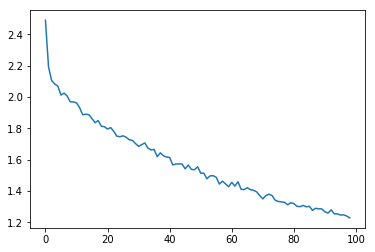

In [23]:
plt.figure()
plt.plot(all_losses)
plt.show();

## 2-Layer 1-Directional LSTM Model

In [24]:
model = LSTMGenerator(EMBEDDING_DIM, HIDDEN_DIM, N_LETTERS, N_LETTERS, num_layers=2)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

all_losses = train(df['words'].values, model, optimizer, loss_function, **params)

1m 17s (1000 1%) 1.9586
Here
Uererer
Wererer
Sererererer
Verererere
None
2m 36s (2000 2%) 2.5024
Sere
Kerere
Gere
Verere
Nererererer
None
3m 54s (3000 3%) 3.8917
Derererer
Anerererer
Erere
Gane
Jerererer
None
5m 11s (4000 4%) 1.8449
Ferere
Lerererer
Xerere
Lere
Derererer
None
6m 35s (5000 5%) 2.9536
Daro
Erororororo
Eroror
Caro
Qeror
None
7m 55s (6000 6%) 1.7361
Hererere
Jarerer
Onere
Serer
Xere
None
9m 15s (7000 7%) 1.9671
Xeraneran
Veraneran
Qaner
Oran
Qaneran
None
10m 30s (8000 8%) 2.4595
Herererere
Nerere
Corerererer
Qererererer
Urerererer
None
11m 49s (9000 9%) 1.4321
Tererere
Ferer
Brererere
Nerererer
Bererer
None
13m 0s (10000 10%) 1.9680
Euelanel
Qelan
Canelanel
Canelanelan
Telanel
None
14m 12s (11000 11%) 2.2605
Relanelanel
Elanel
Orelanela
Janela
Delanelan
None
15m 24s (12000 12%) 1.6947
Wanelan
Ianelane
Belanel
Belanelanel
Orel
None
16m 36s (13000 13%) 2.0125
Fuenen
Urisuenene
Penen
Urisu
Senenenenen
None
17m 48s (14000 14%) 2.3737
Xenenene
Tenenenene
Nenenenene
Fanenenenen


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:62] data. DefaultCPUAllocator: not enough memory: you tried to allocate %dGB. Buy new RAM!0


In [ ]:
plt.figure()
plt.plot(all_losses)
plt.show();

## 1-Layer Bi-Directional LSTM Model

In [ ]:
model = LSTMGenerator(EMBEDDING_DIM, HIDDEN_DIM, N_LETTERS, N_LETTERS, num_layers=2, bidirectional=True)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

all_losses = train(df['words'].values, model, optimizer, loss_function, **params)

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.show();

## Other datasets

https://www.kaggle.com/caesarlupum/gov-names

https://www.kaggle.com/dattapiy/sec-edgar-companies-list

https://www.kaggle.com/dalreada/all-uk-active-company-names